# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center> Regresion Basica con tf.keras: Predecir valores medios de predios</center></span>

##   <span style="color:blue">Estudiante</span>

Héctor Chica, hachica98@gmail.com

## <span style="color:blue">Importa librerías requeridas</span>

In [30]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns




print(tf.__version__)

2.3.0


## <span style="color:blue">Lectura de los datos</span>


Primero descargue el set de datos.

In [31]:
dataset_path = keras.utils.get_file("housing_1.csv", "https://github.com/deephector/cursoIA")
dataset_path

'C:\\Users\\biome3\\.keras\\datasets\\housing_1.csv'

Importelo usando pandas.

In [32]:
import os
os.chdir("E:\DOCTORADO UNIVALLE\Doctorado\datos")
os.getcwd()
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
                'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
raw_dataset = pd.read_csv("housing_1.csv", names=column_names,
                     na_values = "?", comment='\t',
                     # sep=",", skipinitialspace=False
                         )

dataset = raw_dataset.copy()
dataset.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


## <span style="color:blue">Preprocesamiento</span>

### Detecta datos faltantes y elimina filas


El set de datos contiene algunos valores desconocidos.

In [33]:
dataset.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

**Para** Mantener este tutorial inicial sencillo eliminemos las siguientes filas.

In [34]:
dataset = dataset.dropna()

### Dividir los datos en entrenamiento y test


Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

In [35]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [36]:
train_dataset.keys()

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

### Descriptivo de los datos


Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

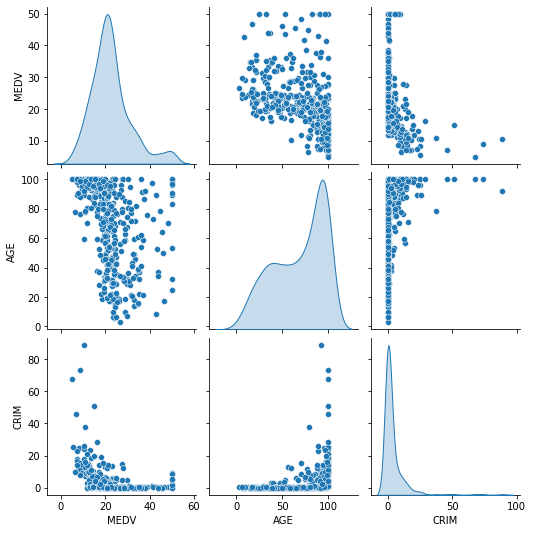

In [37]:
sns.pairplot(train_dataset[["MEDV", "AGE", "CRIM"]], diag_kind="kde")

Tambien revise las estadisticas generales:

In [38]:
train_stats = train_dataset.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,3.670339,8.977954,0.00632,0.08265,0.26838,3.47428,88.9762
ZN,405.0,11.067901,22.688396,0.00000,0.00000,0.00000,12.50000,95.0000
INDUS,405.0,11.097951,6.699157,0.74000,5.32000,9.69000,18.10000,27.7400
CHAS,405.0,0.069136,0.253999,0.00000,0.00000,0.00000,0.00000,1.0000
NOX,405.0,0.553098,0.115564,0.38500,0.44900,0.53800,0.62400,0.8710
RM,405.0,6.269768,0.690552,3.56100,5.87800,6.19300,6.61900,8.7800
AGE,405.0,68.241975,27.908527,2.90000,45.00000,76.50000,94.10000,100.0000
DIS,405.0,3.834098,2.162173,1.12960,2.07880,3.27210,5.21460,12.1265
RAD,405.0,9.474074,8.618564,1.00000,4.00000,5.00000,24.00000,24.0000
TAX,405.0,405.839506,164.057951,187.00000,284.00000,334.00000,666.00000,711.0000


### Separe caracteristicas y etiquetas



Separe el valor objetivo, o la "etiqueta" 
de las caracteristicas. Esta etiqueta es el valor que entrenara el modelo para predecir.

In [39]:
train_labels = train_dataset.pop('MEDV')
test_labels = test_dataset.pop('MEDV')

### Normalice los datos

Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [41]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## <span style="color:blue">Construye el modelo Sequential modo 1</span>

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, `build_model`, ya que crearemos un segundo modelo, más adelante.

In [42]:
normed_train_data.shape[1]

13

In [43]:
model = keras.Sequential([
layers.Dense(32, activation='relu', input_shape=(normed_train_data.shape[1],)),
layers.Dropout(0.2),
layers.Dense(16, activation='relu'),
layers.Dropout(0.2),
layers.Dense(8, activation='relu'),
layers.Dropout(0.2),
layers.Dense(1)
])

## <span style="color:blue">Compila</span>

In [44]:
model.compile(optimizer='adam',
              loss='mse',
                
                metrics=['mae', 'mse'])

### Summary

In [56]:
model.summary()
#plot_model(model, to_file='../talleres/house.png', 
     #      show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9

## <span style="color:blue">Entrena</span>

Entrene el modelo durante 1000 epochs y registre la precisión de entrenamiento y validación en el objeto `history`.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

epochs = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [60]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,30.302336,4.128592,30.302336,9.613641,2.356997,9.613641,995
996,30.663300,4.134506,30.663300,11.072419,2.578005,11.072419,996
997,30.542543,4.096590,30.542543,10.913672,2.546651,10.913672,997
998,30.725471,4.004455,30.725471,10.898061,2.561191,10.898061,998
999,30.468626,3.898307,30.468626,10.173596,2.454461,10.173596,999


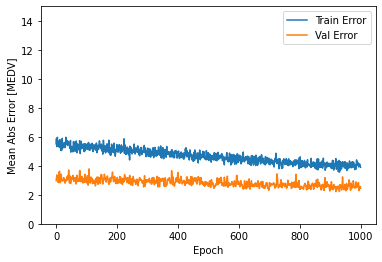

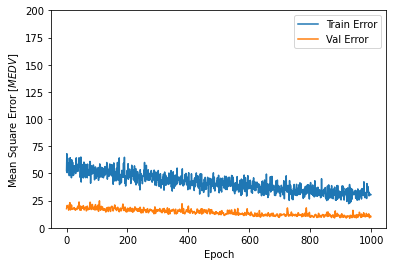

In [61]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MEDV]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,15])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MEDV$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()
  plt.show()


plot_history(history)


................

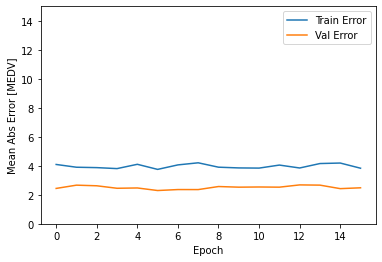

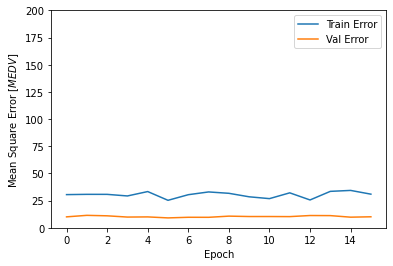

In [62]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2.5 $1000US$. ¿Es esto bueno? Le dejaremos esa decisión a usted.

Veamos qué tan bien generaliza el modelo al usar el conjunto ** test **, que no usamos al entrenar el modelo. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real.

In [63]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MEDV".format(mae))

4/4 - 0s - loss: 7.5346 - mae: 2.1027 - mse: 7.5346
Testing set Mean Abs Error:  2.10 MEDV


## Predicciones

Finalmente, prediga los valores de MPG utilizando datos en el conjunto de pruebas:

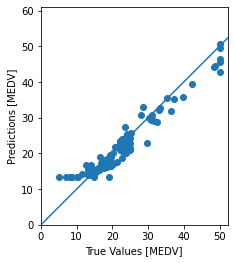

In [64]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


No es del todo ideal el comportamiento de la red para predecir. Se debe mejorar

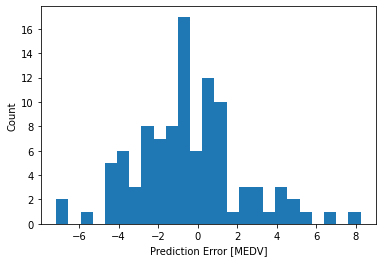

In [65]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")